In [ ]:
%cd /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader

/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader


In [ ]:
!pwd

/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import json
from google.colab.patches import cv2_imshow

# Load JSON configuration
with open('/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/configurations/v1.json', 'r') as file:  # Replace 'config.json' with your JSON file path
    config = json.load(file)

# Load the template image
template_path = config["inputs"]["template"]
template_image = cv2.imread("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg")

if template_image is None:
    print("Error: Template image not found at path:", template_path)
    exit()

# Bubble coordinates configuration
bubble_coords = config["bubble_coordinates"]
start_x = bubble_coords["starting_x"]
start_y = bubble_coords["starting_y"]
x_offset = bubble_coords["x_offset"]
y_offset = bubble_coords["y_offset"]
x_column_offset = bubble_coords["x_column_offset"]
x_adjustment = bubble_coords["x_adjustment"]

# Draw bubbles
columns = bubble_coords["columns"]
for column, col_params in columns.items():
    # Adjust starting y for specific columns if specified
    column_start_y = col_params.get("starting_y", start_y)

    for i in range(10):  # Adjust range as per the number of rows (example: 10 rows here)
        # Calculate bubble position
        bubble_x = start_x + (int(column) - 1) * x_column_offset + x_adjustment
        bubble_y = column_start_y + i * y_offset

        # Draw circle on the template image
        cv2.circle(template_image, (int(bubble_x), int(bubble_y)), 10, (0, 0, 255), 2)  # Circle radius and color

        # Add row and column index
        cv2.putText(template_image, f"({int(column)},{i+1})",
                    (int(bubble_x + 15), int(bubble_y - 15)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

# Save and show the output image
#output_path = "output/marked_template.jpg"
#cv2.imwrite(output_path, template_image)

# Show the image for preview (Optional)
cv2_imshow(template_image)




Output hidden; open in https://colab.research.google.com to view.

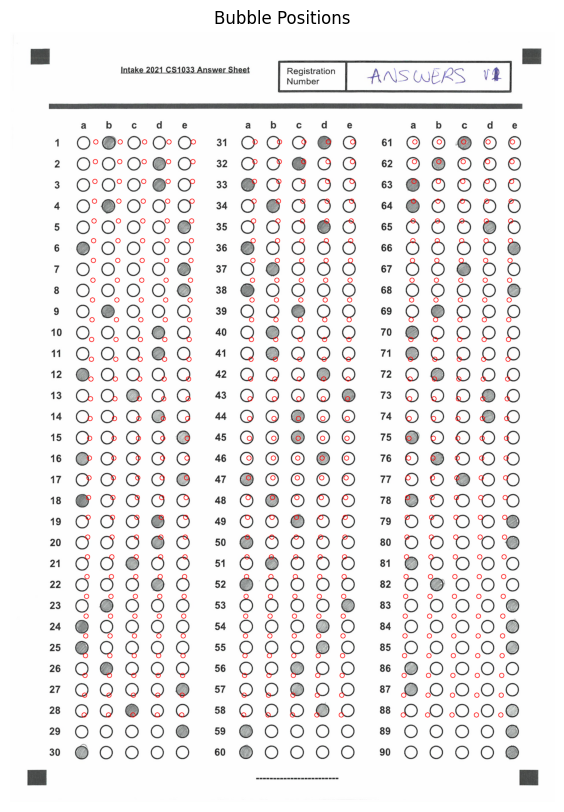

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Functions from the provided code
def get_coordinates_of_bubbles(config):
    x = config['bubble_coordinates']['starting_x']
    y = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']
    coordinates = []
    for i in range(3):  # for every column
        if i == 1:
            y = config['bubble_coordinates']['columns']['2']['starting_y']
        if i == 2:
            y = config['bubble_coordinates']['columns']['3']['starting_y']
        for j in range(30):  # for every question
            for k in range(5):  # for every choice
                __x_offset = k * x_offset
                __y_offset = j * y_offset
                x_i = x + __x_offset
                y_i = y + __y_offset
                a = [int(x_i), int(y_i)]  # Convert to integers
                coordinates.append(a)
            x = x - config['bubble_coordinates']['x_adjustment']
        x += x_column_offset
    return coordinates

def get_corresponding_points(points, H):
    points = np.array(points)
    x = points.shape[0]
    point = np.hstack((points, np.ones((x, 1))))  # Add ones for homography
    point = point.T
    correspondingPoints = np.matmul(H, point).T
    for i in range(x):
        correspondingPoints[i][0] /= correspondingPoints[i][2]
        correspondingPoints[i][1] /= correspondingPoints[i][2]
    return correspondingPoints

# Config: Sample configuration for bubble placement
config = {
    "num_questions": 91,
    "bubble_coordinates": {
        "starting_x": 390,
        "starting_y": 500,
        "x_offset": 111,
        "y_offset": 90,
        "x_column_offset": 780,
        "x_adjustment": 1.8,
        "columns": {
            "2": {"starting_y": 500},
            "3": {"starting_y": 500}
        }
    }
}

# Step 1: Get Bubble Coordinates
bubble_coordinates = get_coordinates_of_bubbles(config)

# Step 2: Homography Transformation (if needed, using identity here for simplicity)
H = np.eye(3)  # Identity matrix, no transformation
mapped_coordinates = get_corresponding_points(bubble_coordinates, H)

# Step 3: Load Image
image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Path to the image
image = cv2.imread(image_path)

# Step 4: Draw Circles on the Image
for coord in mapped_coordinates:
    x, y = int(coord[0]), int(coord[1])
    cv2.circle(image, (x, y), radius=10, color=(0, 0, 255), thickness=2)  # Green circle

# Step 5: Display the Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions")
plt.show()


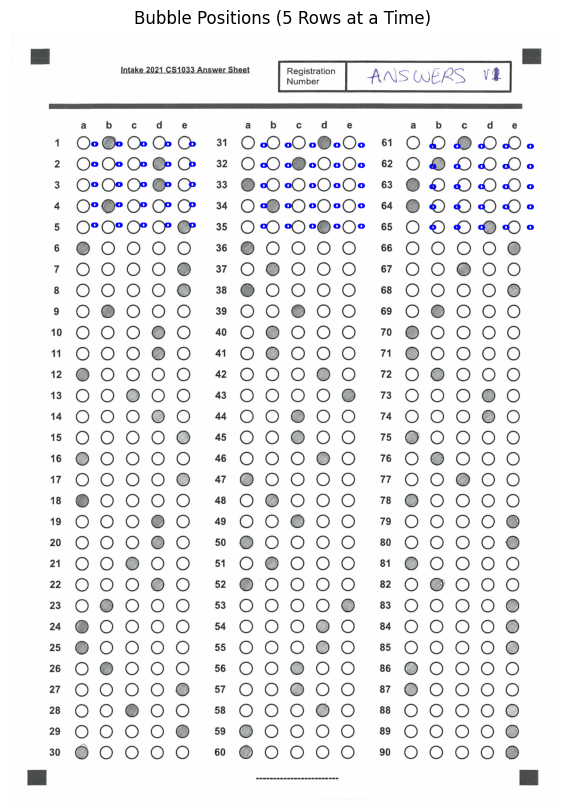

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_by_rows(config, num_rows_per_group=5):
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']
    x_adjustment = config['bubble_coordinates']['x_adjustment']

    coordinates = []
    total_questions = config['num_questions']
    questions_per_column = total_questions // 3

    for column in range(3):  # Loop through each column
        if column == 1:
            y_start = config['bubble_coordinates']['columns']['2']['starting_y']
        if column == 2:
            y_start = config['bubble_coordinates']['columns']['3']['starting_y']

        for group_start in range(0, questions_per_column, num_rows_per_group):
            # Group rows: Process `num_rows_per_group` rows at a time
            for row in range(group_start, group_start + num_rows_per_group):
                if row >= questions_per_column:
                    break  # Stop if rows exceed the limit
                for choice in range(5):  # Loop through 5 answer choices (A, B, C, D, E)
                    x = x_start + (choice * x_offset)
                    y = y_start + ((row - group_start) * y_offset)
                    coordinates.append([int(x), int(y)])

            # Adjust for next group
            x_start -= x_adjustment

        # Move to the next column
        x_start += x_column_offset

    return coordinates

# Sample configuration
config = {
    "num_questions": 90,
    "bubble_coordinates": {
        "starting_x": 390,
        "starting_y": 510,
        "x_offset": 111,
        "y_offset": 92.3,
        "x_column_offset": 780,
        "x_adjustment": 1.8,
        "columns": {
            "2": {"starting_y": 515},
            "3": {"starting_y": 520}
        }
    }
}

# Step 1: Compute Bubble Coordinates by Groups
bubble_coordinates = get_bubble_coordinates_by_rows(config, num_rows_per_group=5)

# Step 2: Load Image
image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Group
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions (5 Rows at a Time)")
plt.show()


# 1

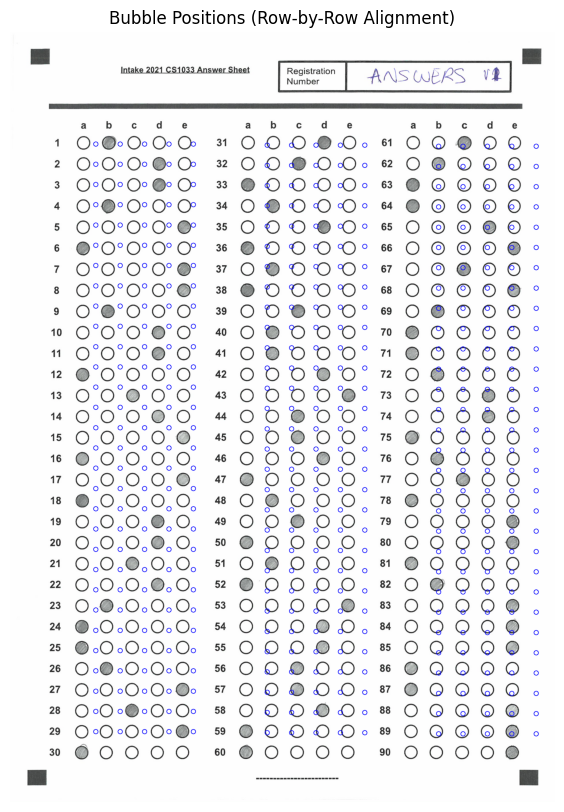

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_by_rows_fixed(config, num_rows_per_group=5):
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']
    x_adjustment = config['bubble_coordinates']['x_adjustment']

    coordinates = []
    total_questions = config['num_questions']
    questions_per_column = total_questions // 3  # Divide total questions into 3 columns

    for column in range(3):  # Loop through each column
        if column == 1:
            y_start = config['bubble_coordinates']['columns']['2']['starting_y']
        if column == 2:
            y_start = config['bubble_coordinates']['columns']['3']['starting_y']

        for group_start in range(0, questions_per_column, num_rows_per_group):
            # Process each group of `num_rows_per_group` rows
            for row in range(group_start, group_start + num_rows_per_group):
                if row >= questions_per_column:
                    break  # Stop if rows exceed the column's question limit
                for choice in range(5):  # Loop through 5 answer choices (A, B, C, D, E)
                    x = x_start + (choice * x_offset)
                    y = y_start + ((row - group_start) * y_offset)  # Adjust y for row
                    coordinates.append([int(x), int(y)])

            # Adjust `y_start` to move to the next group of rows
            y_start += num_rows_per_group * y_offset

        # Adjust for next column
        x_start += x_column_offset
        y_start = config['bubble_coordinates']['starting_y']  # Reset `y_start` for next column

    return coordinates

# Sample configuration
config = {
    "num_questions": 90,
    "bubble_coordinates": {
        "starting_x": 390,
        "starting_y": 510,
        "x_offset": 111,
        "y_offset": 92.3,
        "x_column_offset": 780,
        "x_adjustment": 1.8,
        "columns": {
            "2": {"starting_y": 515},
            "3": {"starting_y": 520}
        }
    }
}

# Step 1: Compute Bubble Coordinates by Groups
bubble_coordinates = get_bubble_coordinates_by_rows_fixed(config, num_rows_per_group=5)

# Step 2: Load Image
image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Group
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions (Row-by-Row Alignment)")
plt.show()


# 2

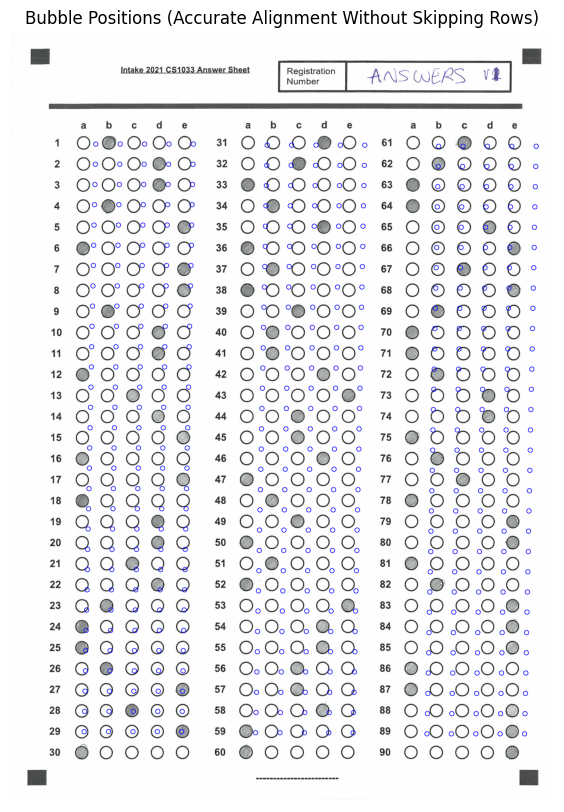

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config, num_rows_per_batch=5):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']
    x_adjustment = config['bubble_coordinates']['x_adjustment']

    coordinates = []
    total_questions = config['num_questions']
    questions_per_column = total_questions // 3  # Divide total questions into 3 columns

    for column in range(3):  # Loop through each column
        if column == 1:
            y_start = config['bubble_coordinates']['columns']['2']['starting_y']
        if column == 2:
            y_start = config['bubble_coordinates']['columns']['3']['starting_y']

        # Starting x and y positions for the column
        column_x_start = x_start
        column_y_start = y_start

        for row in range(questions_per_column):  # Process each question (row) in the column
            # Determine if this row belongs to the current batch
            batch_row_index = row % num_rows_per_batch
            batch_start_y = column_y_start + (row // num_rows_per_batch) * num_rows_per_batch * y_offset

            # Calculate y for this row within the batch
            y_row = batch_start_y + batch_row_index * y_offset

            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                y = y_row
                coordinates.append([int(x), int(y)])

            # Adjust x to account for alignment shifts
            column_x_start -= x_adjustment

        # Reset for the next column
        x_start += x_column_offset

    return coordinates

# Sample configuration
config = {
    "num_questions": 90,
    "bubble_coordinates": {
        "starting_x": 390,
        "starting_y": 510,
        "x_offset": 111,
        "y_offset": 92.3,
        "x_column_offset": 780,
        "x_adjustment": 1.8,
        "columns": {
            "2": {"starting_y": 515},
            "3": {"starting_y": 520}
        }
    }
}

# Step 1: Compute Bubble Coordinates for All Rows Without Gaps
bubble_coordinates = get_bubble_coordinates_aligned(config, num_rows_per_batch=5)

# Step 2: Load Image
image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions (Accurate Alignment Without Skipping Rows)")
plt.show()


# 3 github sample tuning


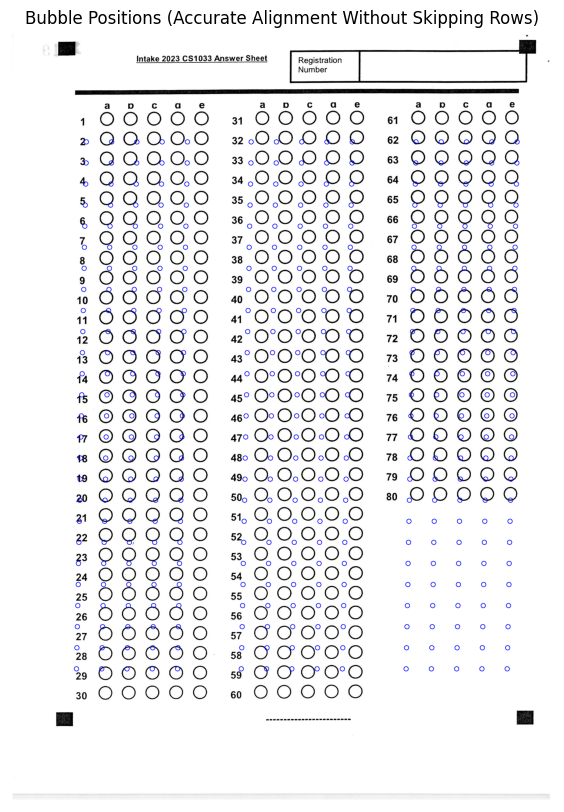

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config, num_rows_per_batch=5):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']
    x_adjustment = config['bubble_coordinates']['x_adjustment']

    coordinates = []
    total_questions = config['num_questions']
    questions_per_column = total_questions // 3  # Divide total questions into 3 columns

    for column in range(3):  # Loop through each column
        if column == 1:
            y_start = config['bubble_coordinates']['columns']['2']['starting_y']
        if column == 2:
            y_start = config['bubble_coordinates']['columns']['3']['starting_y']

        # Starting x and y positions for the column
        column_x_start = x_start
        column_y_start = y_start

        for row in range(questions_per_column):  # Process each question (row) in the column
            # Determine if this row belongs to the current batch
            batch_row_index = row % num_rows_per_batch
            batch_start_y = column_y_start + (row // num_rows_per_batch) * num_rows_per_batch * y_offset

            # Calculate y for this row within the batch
            y_row = batch_start_y + batch_row_index * y_offset

            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                y = y_row
                coordinates.append([int(x), int(y)])

            # Adjust x to account for alignment shifts
            column_x_start -= x_adjustment

        # Reset for the next column
        x_start += x_column_offset

    return coordinates

# Sample configuration
config = {
    "num_questions": 80,
    "bubble_coordinates": {
        "starting_x": 347.9,
        "starting_y": 500,
        "x_offset": 115,
        "y_offset": 96,
        "x_column_offset": 750,
        "x_adjustment": 1.8,
        "columns": {
            "2": {"starting_y": 500},
            "3": {"starting_y": 500}
        }
    }
}

# Step 1: Compute Bubble Coordinates for All Rows Without Gaps
bubble_coordinates = get_bubble_coordinates_aligned(config, num_rows_per_batch=5)

# Step 2: Load Image
image_path = "/content/V1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions (Accurate Alignment Without Skipping Rows)")
plt.show()


# now try this and see


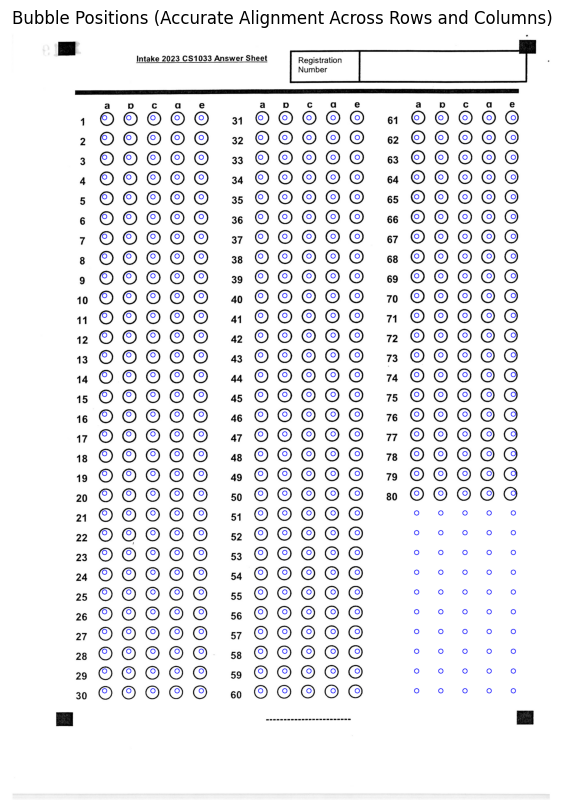

In [ ]:
# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config, num_rows_per_batch=5):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']

    coordinates = []
    total_questions = config['num_questions']
    questions_per_column = total_questions // 3  # Divide total questions into 3 columns

    # Precompute consistent y positions for all rows
    consistent_y_positions = [
        y_start + row * y_offset for row in range(questions_per_column)
    ]

    for column in range(3):  # Loop through each column
        # Starting x for the column
        column_x_start = x_start + column * x_column_offset

        for row, y_row in enumerate(consistent_y_positions):  # Process each question (row) in the column
            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                coordinates.append([int(x), int(y_row)])

    return coordinates

# Sample configuration
config = {
    "num_questions": 90,
    "bubble_coordinates": {
        "starting_x": 430,
        "starting_y": 390,
        "x_offset": 110,
        "y_offset": 90,
        "x_column_offset": 710,
        "columns": {
            "2": {"starting_y": 380},  # Align with starting_y of the first column
            "3": {"starting_y": 380}   # Align with starting_y of the first column
        }
    }
}

# Step 1: Compute Bubble Coordinates for All Rows Without Gaps
bubble_coordinates = get_bubble_coordinates_aligned(config, num_rows_per_batch=5)

# Step 2: Load Image
image_path = "/content/V1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions (Accurate Alignment Across Rows and Columns)")
plt.show()


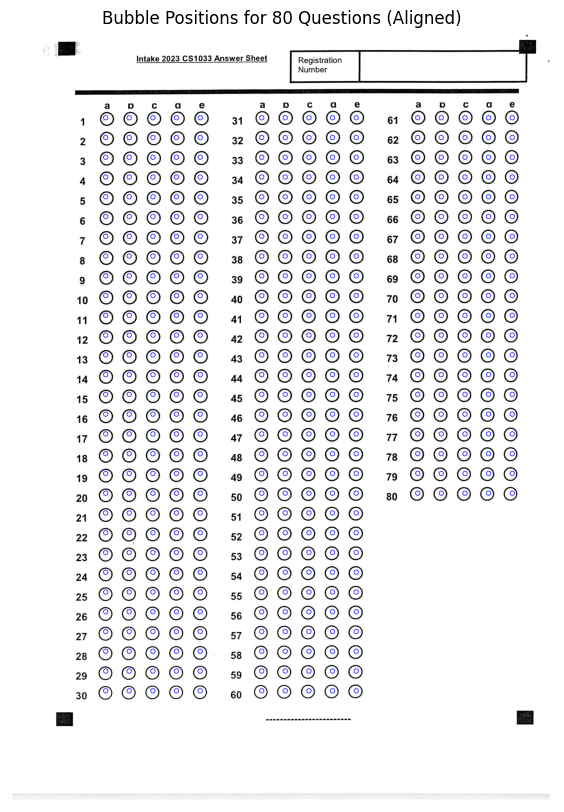

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    y_start = config['bubble_coordinates']['starting_y']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']

    coordinates = []
    column_row_distribution = [30, 30, 20]  # Rows for each column

    for column, num_rows in enumerate(column_row_distribution):  # Loop through each column
        # Starting x for the column
        column_x_start = x_start + column * x_column_offset

        for row in range(num_rows):  # Process each question (row) in the column
            y_row = y_start + row * y_offset
            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                coordinates.append([int(x), int(y_row)])

    return coordinates

# Sample configuration for 80 questions
config = {
    "num_questions": 80,
    "bubble_coordinates": {
        "starting_x": 435,
        "starting_y": 390,
        "x_offset": 107.5,
        "y_offset": 90,
        "x_column_offset": 710,
    }
}

# Step 1: Compute Bubble Coordinates for 80 Questions
bubble_coordinates = get_bubble_coordinates_aligned(config)

# Step 2: Load Image
image_path = "/content/V1.jpg"  # Path to the uploaded image
image = cv2.imread(image_path)

# Step 3: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 4: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions for 80 Questions (Aligned)")
plt.show()


# V1

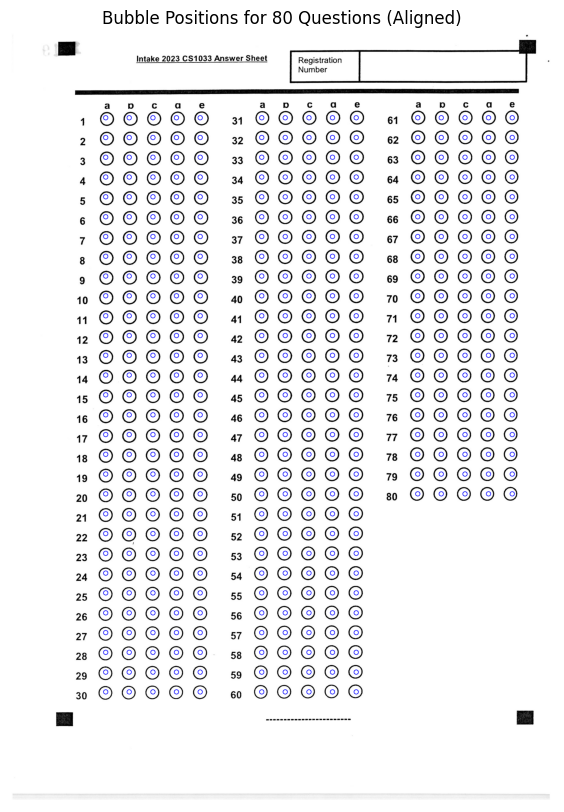

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']

    # Starting y coordinates for each column
    y_start_col1 = config['bubble_coordinates']['starting_y']
    y_start_col2 = config['bubble_coordinates']['columns']['2']['starting_y']
    y_start_col3 = config['bubble_coordinates']['columns']['3']['starting_y']
    column_y_starts = [y_start_col1, y_start_col2, y_start_col3]

    coordinates = []
    column_row_distribution = [30, 30, 20]  # Rows for each column

    for column, (num_rows, y_start) in enumerate(zip(column_row_distribution, column_y_starts)):
        # Starting x for the column
        column_x_start = x_start + column * x_column_offset

        for row in range(num_rows):  # Process each question (row) in the column
            y_row = y_start + row * y_offset
            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                coordinates.append([int(x), int(y_row)])

    return coordinates

# Sample configuration for 80 questions
config = {
    "num_questions": 80,
    "bubble_coordinates": {
        "starting_x": 435,
        "starting_y": 390,
        "x_offset": 107.5,
        "y_offset": 90.2,
        "x_column_offset": 710,
        "columns": {
            "2": {"starting_y": 390},  # Second column's starting Y coordinate
            "3": {"starting_y": 390},  # Third column's starting Y coordinate
        }
    },
    "image_processing": {
        "enhance_contrast": 10
    }
}

# Upload image to Colab
# uploaded = files.upload()  # Upload the image file here

# Step 1: Compute Bubble Coordinates for 80 Questions
bubble_coordinates = get_bubble_coordinates_aligned(config)

# Step 2: Load Image
# image_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
image = cv2.imread("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/blank-templates/V1.jpg")

# Step 3: Check if Image is Loaded Correctly
if image is None:
    raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded!")

# Step 4: Enhance Image Contrast if Specified
if "image_processing" in config and "enhance_contrast" in config["image_processing"]:
    alpha = config["image_processing"]["enhance_contrast"] / 10  # Scaling factor
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)

# Step 5: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 6: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions for 80 Questions (Aligned)")
plt.show()


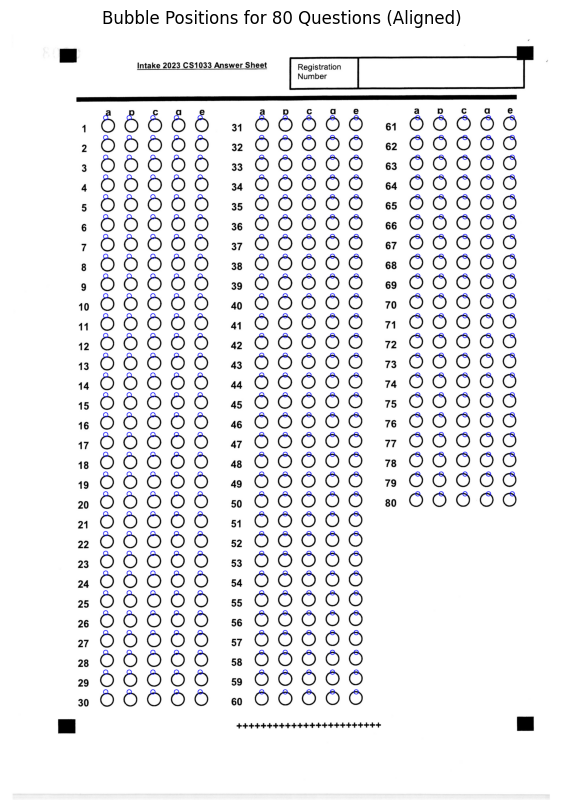

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Function to calculate bubble coordinates row by row
def get_bubble_coordinates_aligned(config):
    # Configuration parameters
    x_start = config['bubble_coordinates']['starting_x']
    x_offset = config['bubble_coordinates']['x_offset']
    y_offset = config['bubble_coordinates']['y_offset']
    x_column_offset = config['bubble_coordinates']['x_column_offset']

    # Starting y coordinates for each column
    y_start_col1 = config['bubble_coordinates']['starting_y']
    y_start_col2 = config['bubble_coordinates']['columns']['2']['starting_y']
    y_start_col3 = config['bubble_coordinates']['columns']['3']['starting_y']
    column_y_starts = [y_start_col1, y_start_col2, y_start_col3]

    coordinates = []
    column_row_distribution = [30, 30, 20]  # Rows for each column

    for column, (num_rows, y_start) in enumerate(zip(column_row_distribution, column_y_starts)):
        # Starting x for the column
        column_x_start = x_start + column * x_column_offset

        for row in range(num_rows):  # Process each question (row) in the column
            y_row = y_start + row * y_offset
            for choice in range(5):  # Process the 5 answer choices (a, b, c, d, e)
                x = column_x_start + (choice * x_offset)
                coordinates.append([int(x), int(y_row)])

    return coordinates

# Sample configuration for 80 questions
config = {
    "num_questions": 80,
    "bubble_coordinates": {
        "starting_x": 435,
        "starting_y": 390,
        "x_offset": 107.5,
        "y_offset": 90.2,
        "x_column_offset": 710,
        "columns": {
            "2": {"starting_y": 390},  # Second column's starting Y coordinate
            "3": {"starting_y": 390},  # Third column's starting Y coordinate
        }
    },
    "image_processing": {
        "enhance_contrast": 10
    }
}

# Upload image to Colab
# uploaded = files.upload()  # Upload the image file here

# Step 1: Compute Bubble Coordinates for 80 Questions
bubble_coordinates = get_bubble_coordinates_aligned(config)

# Step 2: Load Image
# image_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
image = cv2.imread("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/blank-templates/V2.jpg")

# Step 3: Check if Image is Loaded Correctly
if image is None:
    raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded!")

# Step 4: Enhance Image Contrast if Specified
if "image_processing" in config and "enhance_contrast" in config["image_processing"]:
    alpha = config["image_processing"]["enhance_contrast"] / 10  # Scaling factor
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)

# Step 5: Draw Circles on Image for Each Bubble Coordinate
for coord in bubble_coordinates:
    x, y = coord[0], coord[1]
    cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)  # Blue circles

# Step 6: Display Result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bubble Positions for 80 Questions (Aligned)")
plt.show()


In [ ]:
!pwd

/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader


# v1 run

In [ ]:
!python3 mcqautograder/autograder.py --template 2023-answers-scanned/blank-templates/V1.jpg --markingscheme 2023-answers-scanned/marking-scheme/V1-MODEL_ANSWERS.jpg --answers /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V1/ --studentslist /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/student_listv1.csv --output output/V1_final/ --version 1 --showmarked

Running autograder...
Reading configurations from configurations/v1.json
Visualization saved at output/V1_final/bubble_coordinates_visualization.png
Figure(1000x1000)
1 Result for 21001A: 46/80, Incorrect: 34, More than one: 0, Not marked: 0
Figure(1000x1000)
2 Result for 21002A: 49/80, Incorrect: 31, More than one: 0, Not marked: 0
Figure(1000x1000)
3 Result for 21003A: 60/80, Incorrect: 20, More than one: 0, Not marked: 0
Figure(1000x1000)
4 Result for 21004A: 62/80, Incorrect: 18, More than one: 0, Not marked: 0
Figure(1000x1000)
5 Result for 21005A: 64/80, Incorrect: 16, More than one: 0, Not marked: 0
Figure(1000x1000)
6 Result for 21006A: 53/80, Incorrect: 27, More than one: 0, Not marked: 0
Figure(1000x1000)
7 Result for 21007A: 61/80, Incorrect: 19, More than one: 0, Not marked: 0
Figure(1000x1000)
8 Result for 21008A: 45/80, Incorrect: 35, More than one: 0, Not marked: 0
Figure(1000x1000)
9 Result for 21009A: 36/80, Incorrect: 43, More than one: 1, Not marked: 0
Figure(1000x10

# V2 run

In [ ]:
!python3 mcqautograder/autograder.py --template 2023-answers-scanned/blank-templates/V1.jpg --markingscheme 2023-answers-scanned/marking-scheme/V2-MODEL_ANSWERS.jpg --answers /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V2/ --studentslist /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/student_listv2.csv --output output/V2_final/ --version 1 --savemarked

Running autograder...
Reading configurations from configurations/v1.json
Visualization saved at output/V2_final/bubble_coordinates_visualization.png
1 Result for 21001A: 51/80, Incorrect: 29, More than one: 0, Not marked: 0
2 Result for 21002A: 60/80, Incorrect: 19, More than one: 0, Not marked: 1
3 Result for 21003A: 65/80, Incorrect: 15, More than one: 0, Not marked: 0
4 Result for 21004A: 72/80, Incorrect: 8, More than one: 0, Not marked: 0
5 Result for 21005A: 66/80, Incorrect: 14, More than one: 0, Not marked: 0
6 Result for 21006A: 59/80, Incorrect: 21, More than one: 0, Not marked: 0
7 Result for 21007A: 52/80, Incorrect: 25, More than one: 2, Not marked: 1
8 Result for 21008A: 62/80, Incorrect: 18, More than one: 0, Not marked: 0
9 Result for 21009A: 53/80, Incorrect: 27, More than one: 0, Not marked: 0
10 Result for 21010A: 52/80, Incorrect: 28, More than one: 0, Not marked: 0
11 Result for 21011A: 48/80, Incorrect: 25, More than one: 0, Not marked: 7
12 Result for 21012A: 67/

# V3 run

In [ ]:
!python3 mcqautograder/autograder.py --template 2023-answers-scanned/blank-templates/V1.jpg --markingscheme 2023-answers-scanned/marking-scheme/V3-MODEL_ANSWERS.jpg --answers /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V3/ --studentslist /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/student_listv3.csv --output output/V3_final/ --version 1 --savemarked

Running autograder...
Reading configurations from configurations/v1.json
Visualization saved at output/V3_final/bubble_coordinates_visualization.png
1 Result for 21001A: 63/80, Incorrect: 17, More than one: 0, Not marked: 0
2 Result for 21002A: 50/80, Incorrect: 30, More than one: 0, Not marked: 0
3 Result for 21003A: 59/80, Incorrect: 20, More than one: 0, Not marked: 1
4 Result for 21004A: 40/80, Incorrect: 40, More than one: 0, Not marked: 0
5 Result for 21005A: 59/80, Incorrect: 20, More than one: 0, Not marked: 1
6 Result for 21006A: 57/80, Incorrect: 23, More than one: 0, Not marked: 0
7 Result for 21007A: 52/80, Incorrect: 28, More than one: 0, Not marked: 0
8 Result for 21008A: 58/80, Incorrect: 22, More than one: 0, Not marked: 0
9 Result for 21009A: 55/80, Incorrect: 25, More than one: 0, Not marked: 0
10 Result for 21010A: 70/80, Incorrect: 10, More than one: 0, Not marked: 0
11 Result for 21011A: 50/80, Incorrect: 29, More than one: 1, Not marked: 0
12 Result for 21012A: 46

# v4 run

In [23]:
!python3 mcqautograder/autograder.py --template 2023-answers-scanned/blank-templates/V1.jpg --markingscheme 2023-answers-scanned/marking-scheme/V4-MODEL_ANSWERS.jpg --answers /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V4/ --studentslist /content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/student_listv4.csv --output output/V4_final/ --version 1 --showmarked

Running autograder...
Reading configurations from configurations/v1.json
Visualization saved at output/V4_final/bubble_coordinates_visualization.png
Figure(1000x1000)
1 Result for 21001A: 55/80, Incorrect: 25, More than one: 0, Not marked: 0
Figure(1000x1000)
2 Result for 21002A: 55/80, Incorrect: 25, More than one: 0, Not marked: 0
Figure(1000x1000)
3 Result for 21003A: 58/80, Incorrect: 21, More than one: 1, Not marked: 0
Figure(1000x1000)
4 Result for 21004A: 53/80, Incorrect: 25, More than one: 2, Not marked: 0
Figure(1000x1000)
5 Result for 21005A: 40/80, Incorrect: 40, More than one: 0, Not marked: 0
Figure(1000x1000)
6 Result for 21006A: 70/80, Incorrect: 10, More than one: 0, Not marked: 0
Figure(1000x1000)
7 Result for 21007A: 68/80, Incorrect: 10, More than one: 2, Not marked: 0
Figure(1000x1000)
8 Result for 21008A: 72/80, Incorrect: 8, More than one: 0, Not marked: 0
Figure(1000x1000)
9 Result for 21009A: 48/80, Incorrect: 32, More than one: 0, Not marked: 0
Figure(1000x100

In [ ]:
import os

# Specify the folder path in your Google Drive
folder_path = '/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V4'

# Count the number of files in the folder
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Number of files in the folder: {file_count}")

Number of files in the folder: 272


# checking the files

In [ ]:
import os
import cv2

def check_common_shape(folder_path):
    """
    Check if all images in a folder have the same shape and print the common shape.

    Args:
        folder_path (str): Path to the folder containing images.
    """
    shapes = {}
    common_shape = None
    consistent = True

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Skip non-image files
        if not file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff')):
            print(f"Skipping non-image file: {file_name}")
            continue

        # Read the image and get its shape
        try:
            image = cv2.imread(file_path)
            if image is None:
                print(f"Error reading file: {file_name}")
                continue

            shape = image.shape[:2]  # (height, width)
            if shape not in shapes:
                shapes[shape] = []
            shapes[shape].append(file_name)

            # Check for consistency
            if common_shape is None:
                common_shape = shape
            elif shape != common_shape:
                consistent = False

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Output results
    if consistent and common_shape:
        print(f"All images have the same shape: {common_shape}")
    else:
        print("Shapes of images are not consistent:")
        for shape, files in shapes.items():
            print(f"Shape {shape}: {len(files)} file(s) - {files}")

# Example usage
folder_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/2023-answers-scanned/student-answers/V1"
check_common_shape(folder_path)


All images have the same shape: (3507, 2480)


# printing files shapes in the folder

In [ ]:
import os
import cv2

def check_common_shape(folder_path):
    """
    Check if all images in a folder have the same shape and print the common shape.

    Args:
        folder_path (str): Path to the folder containing images.
    """
    shapes = {}
    common_shape = None
    consistent = True

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Skip non-image files
        if not file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff')):
            print(f"Skipping non-image file: {file_name}")
            continue

        # Read the image and get its shape
        try:
            image = cv2.imread(file_path)
            if image is None:
                print(f"Error reading file: {file_name}")
                continue

            shape = image.shape[:2]  # (height, width)
            if shape not in shapes:
                shapes[shape] = []
            shapes[shape].append(file_name)

            # Check for consistency
            if common_shape is None:
                common_shape = shape
            elif shape != common_shape:
                consistent = False

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Output results
    if consistent and common_shape:
        print(f"All images have the same shape: {common_shape}")
    else:
        print("Shapes of images are not consistent:")
        for shape, files in shapes.items():
            print(f"Shape {shape}: {len(files)} file(s) - {files}")

# Example usage
folder_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/templates"
check_common_shape(folder_path)


In [ ]:
import os
import cv2

def resize_images_to_target_shape_opencv(input_folder, target_image_path, output_folder):
    """
    Resize all images in a folder to match the shape of a target image using OpenCV.

    Args:
        input_folder (str): Path to the folder containing source images.
        target_image_path (str): Path to the target image.
        output_folder (str): Path to the folder where resized images will be saved.
    """
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Read the target image to get the desired size
        target_image = cv2.imread(target_image_path)
        if target_image is None:
            raise ValueError(f"Target image not found: {target_image_path}")
        target_height, target_width = target_image.shape[:2]

        # Iterate through all files in the input folder
        for file_name in os.listdir(input_folder):
            input_path = os.path.join(input_folder, file_name)

            # Skip non-image files
            if not file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff')):
                print(f"Skipping non-image file: {file_name}")
                continue

            # Read, resize, and save each image
            try:
                source_image = cv2.imread(input_path)
                if source_image is None:
                    print(f"Error reading image: {file_name}")
                    continue

                resized_image = cv2.resize(source_image, (target_width, target_height), interpolation=cv2.INTER_AREA)
                output_path = os.path.join(output_folder, file_name)
                cv2.imwrite(output_path, resized_image)
                print(f"Resized and saved: {file_name}")
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
input_folder = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/templates"        # Folder containing images to resize
target_image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Path to target image
output_folder = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/template"       # Folder to save resized images

resize_images_to_target_shape_opencv(input_folder, target_image_path, output_folder)


Resized and saved: 2.jpg
Resized and saved: 1.jpg


In [ ]:
template_image1 = cv2.imread("/content/V1.jpg")
template_image2 = cv2.imread("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg")
template_image3 = cv2.imread("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/answers/SKM_558e22122315350_0001.jpg")

In [ ]:
template_image1.shape

(3507, 2480, 3)

In [ ]:
template_image2.shape

(3507, 2480, 3)

In [ ]:
template_image3.shape

(3507, 2480, 3)

In [ ]:

!pip install segment-anything opencv-python-headless matplotlib torch torchvision


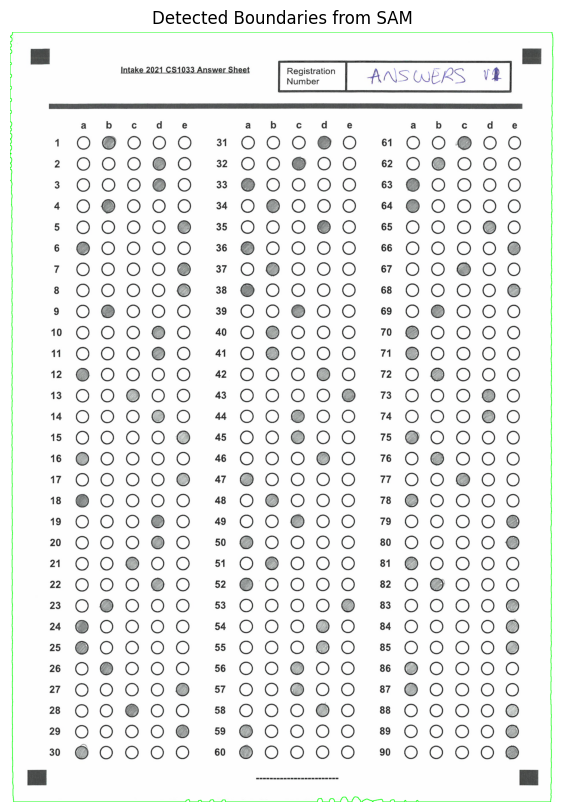

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import SamPredictor, sam_model_registry

# Load SAM model
def load_sam_model(model_type="vit_b", checkpoint_path="sam_vit_b_01ec64.pth"):
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to("cuda" if torch.cuda.is_available() else "cpu")
    return SamPredictor(sam)

# Function to plot detected boundaries
def plot_detected_boundaries(image, masks):
    """
    Plot detected boundaries from SAM on the original image.
    :param image: Input image as numpy array.
    :param masks: List of binary masks from SAM.
    """
    # Copy the image to overlay boundaries
    image_with_boundaries = image.copy()

    for mask in masks:
        # Convert mask to binary format
        binary_mask = (mask > 0).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Draw contours on the image
        cv2.drawContours(image_with_boundaries, contours, -1, (0, 255, 0), 2)  # Green contours

    # Display the image with detected boundaries
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Boundaries from SAM")
    plt.show()

# Load the image and SAM model
image_path = "/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/samples/marking_schemes/1.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize SAM
checkpoint_path = "sam_vit_b_01ec64.pth"  # Replace with your downloaded SAM checkpoint path
predictor = load_sam_model(model_type="vit_b", checkpoint_path=checkpoint_path)
predictor.set_image(image_rgb)

# Generate SAM masks
masks, _, _ = predictor.predict(
    point_coords=None,  # Optionally provide points for specific areas
    point_labels=None,
    box=None,
    multimask_output=True
)

# Plot detected boundaries
plot_detected_boundaries(image, masks)


In [ ]:
!ls

configurations	mcqautograder  pyproject.toml  samples		     tests
LICENSE		output	       README.md       sam_vit_b_01ec64.pth


In [ ]:
index = [ str(21000+i)+"A" for i in range(1,271)]

In [11]:
import pandas as pd

In [62]:
df = pd.read_csv("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/output/V4_final/v1_output.csv")

In [63]:
df

Index No  Autograded Final Mark More than one choice marked  \
0     21001A                     55                          []   
1     21002A                     55                          []   
2     21003A                     58                        [20]   
3     21004A                     53                    [11, 79]   
4     21005A                     40                          []   
..       ...                    ...                         ...   
267   21268A                     35                          []   
268   21269A                     28                          []   
269   21270A                     25                          []   
270   21271A                     24                          []   
271   21272A                     36                          []   

    No choices marked  Column 1 Total  Column 2 Total  Column 3 Total  \
0                  []              19              23              13   
1                  []              17              28              10   
2                  []              18              25              15   
3                  []              17              26              10   
4                  []              18              17               5   
..                ...             ...             ...             ...   
267                []              11              19               5   
268                []               8              12               8   
269                []               9              13               3   
270                []               8               8               8   
271                []              14              14               8   

                                         Answer Script  
0    /content/drive/MyDrive/Document_Digitization_V...  
1    /content/drive/MyDrive/Document_Digitization_V...  
2    /content/drive/MyDrive/Document_Digitization_V...  
3    /content/drive/MyDrive/Document_Digitization_V...  
4    /content/drive/MyDrive/Document_Digitization_V...  
..                                                 ...  
267  /content/drive/MyDrive/Document_Digitization_V...  
268  /content/drive/MyDrive/Document_Digitization_V...  
269  /content/drive/MyDrive/Document_Digitization_V...  
270  /content/drive/MyDrive/Document_Digitization_V...  
271  /content/drive/MyDrive/Document_Digitization_V...  

[272 rows x 8 columns]

In [64]:
new_df = df.iloc[:, [0,1,2,3,-1]]

In [65]:
new_df

Index No  Autograded Final Mark More than one choice marked  \
0     21001A                     55                          []   
1     21002A                     55                          []   
2     21003A                     58                        [20]   
3     21004A                     53                    [11, 79]   
4     21005A                     40                          []   
..       ...                    ...                         ...   
267   21268A                     35                          []   
268   21269A                     28                          []   
269   21270A                     25                          []   
270   21271A                     24                          []   
271   21272A                     36                          []   

    No choices marked                                      Answer Script  
0                  []  /content/drive/MyDrive/Document_Digitization_V...  
1                  []  /content/drive/MyDrive/Document_Digitization_V...  
2                  []  /content/drive/MyDrive/Document_Digitization_V...  
3                  []  /content/drive/MyDrive/Document_Digitization_V...  
4                  []  /content/drive/MyDrive/Document_Digitization_V...  
..                ...                                                ...  
267                []  /content/drive/MyDrive/Document_Digitization_V...  
268                []  /content/drive/MyDrive/Document_Digitization_V...  
269                []  /content/drive/MyDrive/Document_Digitization_V...  
270                []  /content/drive/MyDrive/Document_Digitization_V...  
271                []  /content/drive/MyDrive/Document_Digitization_V...  

[272 rows x 5 columns]

In [66]:
new_df.to_csv("/content/drive/MyDrive/Document_Digitization_VLM/MCQAutoGrader/output/V4_final/V4-output.csv", index=False)

In [ ]:
df = pd.DataFrame(data={"Index No":index})

In [ ]:
df.head()

Index No
0   21001A
1   21002A
2   21003A
3   21004A
4   21005A

In [ ]:
df["version"] = 1

In [ ]:
df.head()

Index No  version
0   21001A        1
1   21002A        1
2   21003A        1
3   21004A        1
4   21005A        1

In [ ]:
df.to_csv("student_list.csv",index=False)